# Подготовка данных и модели

In [1]:
import torch
from torch import nn
import cv2
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import numpy as np


normal_images_train = [cv2.imread(os.path.join('./dataset/train', fn)) for fn in tqdm(os.listdir('./dataset/train'))]
images_test = [cv2.imread(os.path.join('./dataset/test/imgs', fn)) for fn in tqdm(os.listdir('./dataset/test/imgs'))]
abnormal_images = [cv2.imread(os.path.join('./dataset/proliv', fn)) for fn in tqdm(os.listdir('./dataset/proliv'))]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

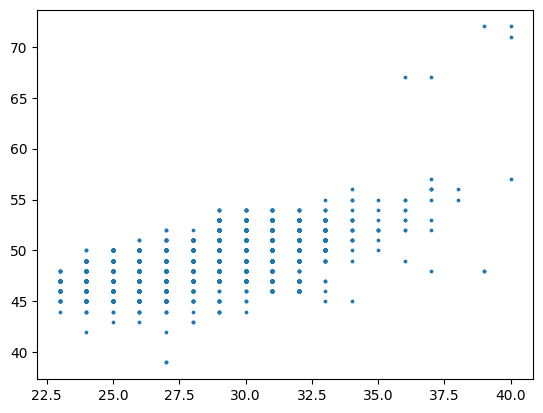

In [2]:
shapes = [i.shape[:2] for i in normal_images_train] + [i.shape[:2] for i in images_test] + [i.shape[:2] for i in abnormal_images]
shapes = np.array(shapes)

plt.scatter(shapes[:, 0], shapes[:, 1], s=3)

In [3]:
def initial_transforms(image):
    image = cv2.resize(image, (60, 60), interpolation=cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = torch.FloatTensor(image / 255).unsqueeze(0)

    return image

normal_images_train = torch.stack(list(map(initial_transforms, normal_images_train)))
images_test = torch.stack(list(map(initial_transforms, images_test)))
abnormal_images = torch.stack(list(map(initial_transforms, abnormal_images)))

In [4]:
class ReconstuctionAutoencoder(nn.Module):
    def __init__(self, scale_factor=1):
        super(ReconstuctionAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, int(16*scale_factor), 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(int(16*scale_factor), int(32*scale_factor), 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(int(32*scale_factor), int(64*scale_factor), 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(int(64*scale_factor), int(128*scale_factor), 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(int(128*scale_factor), int(256*scale_factor), 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(int(256*scale_factor), int(256*scale_factor), 2, 2),
            nn.Conv2d(int(256*scale_factor), int(128*scale_factor), 3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(int(128*scale_factor), int(128*scale_factor), 2, 2),
            nn.Conv2d(int(128*scale_factor), int(64*scale_factor), 3, padding=2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(int(64*scale_factor), int(64*scale_factor), 2, 2),
            nn.Conv2d(int(64*scale_factor), int(32*scale_factor), 3, padding=2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(int(32*scale_factor), int(32*scale_factor), 2, 2),
            nn.Conv2d(int(32*scale_factor), int(16*scale_factor), 3, padding=2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(int(16*scale_factor), int(16*scale_factor), 2, 2),
            nn.Conv2d(int(16*scale_factor), 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent_x = self.encoder(x)
        reconstructed_x = self.decoder(latent_x)

        return reconstructed_x

# Обучение модели и определение референсных значений ошибки реконструкции

In [377]:
from torchinfo import summary

epochs = 25
batch_size = 256
dsize = (60, 60)
huber_delta = 0.1

model = ReconstuctionAutoencoder(scale_factor=0.75)

summary(model, input_size=(batch_size, 1, dsize[1], dsize[0]), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
ReconstuctionAutoencoder                 [256, 1, 60, 60]          --
├─Sequential: 1-1                        [256, 192, 1, 1]          --
│    └─Conv2d: 2-1                       [256, 12, 60, 60]         120
│    └─ReLU: 2-2                         [256, 12, 60, 60]         --
│    └─MaxPool2d: 2-3                    [256, 12, 30, 30]         --
│    └─Conv2d: 2-4                       [256, 24, 30, 30]         2,616
│    └─ReLU: 2-5                         [256, 24, 30, 30]         --
│    └─MaxPool2d: 2-6                    [256, 24, 15, 15]         --
│    └─Conv2d: 2-7                       [256, 48, 15, 15]         10,416
│    └─ReLU: 2-8                         [256, 48, 15, 15]         --
│    └─MaxPool2d: 2-9                    [256, 48, 7, 7]           --
│    └─Conv2d: 2-10                      [256, 96, 7, 7]           41,568
│    └─ReLU: 2-11                        [256, 96, 7, 7]           --
│  

In [378]:
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as T


def add_random_noise(image):
    image += torch.cuda.FloatTensor(*image.shape).normal_(0, 0.1)

    return image


class RMSELoss(object):
    def __init__(self, reduction='mean'):
        self.reduction = reduction

    def __call__(self, x, x_reconstructed):
        return torch.sqrt(nn.functional.mse_loss(x, x_reconstructed, reduction=self.reduction))


train_transforms = T.Compose([T.Normalize(mean=0, std=1),
                              add_random_noise])

train_dataset = TensorDataset(normal_images_train)
abnormal_images_dataset = TensorDataset(abnormal_images)


train_loader = DataLoader(train_dataset, batch_size=batch_size)

# хочу по ходу обучения отследить динамику ошибки для нормальных и аномальных изображений
abnormal_images_loader = DataLoader(abnormal_images_dataset, batch_size=batch_size)

criterion = nn.HuberLoss(delta=huber_delta)
criterion_wo_reduction = nn.HuberLoss(delta=huber_delta, reduction='none')

# criterion = RMSELoss()
# criterion_wo_reduction = RMSELoss(reduction='none')

# criterion = nn.MSELoss()
# criterion_wo_reduction = nn.MSELoss(reduction='none')

optimizer = torch.optim.NAdam(model.parameters())

train_loss_history = list()
abnormal_images_loss_history = list()

model.to('cuda')

for epoch in tqdm(range(epochs)):
    model.train()

    train_loss = 0
    for i, (x, ) in enumerate(train_loader):
        optimizer.zero_grad()
        
        x = x.to('cuda')
        x_reconstructed = model(train_transforms(x))
        
        loss = criterion(x_reconstructed, x)
        train_loss += loss.item()

        if epoch % 5 == 0:
            print(f'\rEpoch {epoch}/{epochs}, {i+1}/{len(train_loader)}: loss: {train_loss/(i+1)}', end='')

        loss.backward()
        optimizer.step()

    train_loss_history.append(train_loss / len(train_loader))
    
    model.eval()

    abnormal_images_loss = 0
    for i, (x,) in enumerate(abnormal_images_loader):
        x = x.to('cuda')

        with torch.no_grad():
            x_reconstructed = model(x)
        
        loss = criterion(x_reconstructed, x)
        abnormal_images_loss += loss.item()
        
    if epoch % 5 == 0:    
        print(f', abnormal samples loss: {abnormal_images_loss/len(abnormal_images_loader)}')
    abnormal_images_loss_history.append(abnormal_images_loss)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25, 40/40: loss: 0.0010296543245203794, abnormal samples loss: 0.0024741063825786114
Epoch 5/25, 40/40: loss: 0.0007586398685816675, abnormal samples loss: 0.002453156979754567
Epoch 10/25, 40/40: loss: 0.0007587353291455656, abnormal samples loss: 0.0024429806508123875
Epoch 15/25, 40/40: loss: 0.0007530531904194504, abnormal samples loss: 0.002452598884701729
Epoch 20/25, 40/40: loss: 0.0007514094351790846, abnormal samples loss: 0.002495161723345518


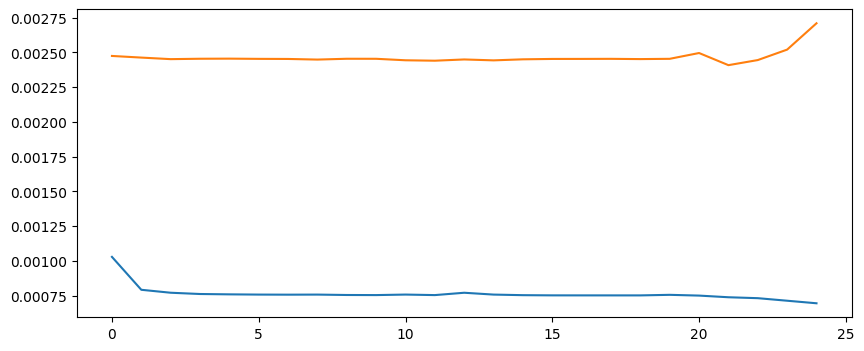

In [379]:
plt.figure(figsize=(10, 4))

plt.plot(train_loss_history, label='train normal images loss')
plt.plot(abnormal_images_loss_history, label='abnormal images loss')

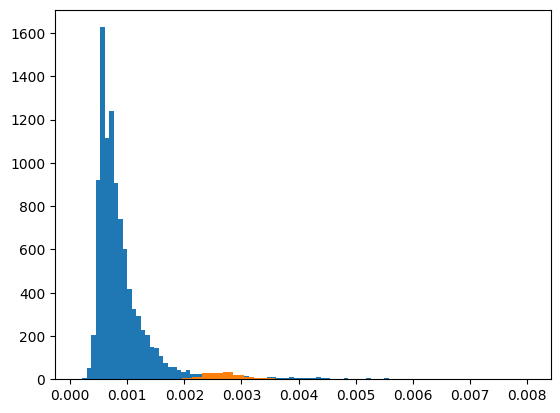

In [380]:
train_reconstructed_images = list()
abnormal_reconstructed_images = list()

train_original_images = list()
abnormal_original_images = list()

with torch.no_grad():
    for i, (x,) in enumerate(train_loader):
        optimizer.zero_grad()
        
        x = x.to('cuda')
        x_reconstructed = model(train_transforms(x))
        
        train_reconstructed_images.append(x_reconstructed.cpu())
        train_original_images.append(x.cpu())

    for i, (x,) in enumerate(abnormal_images_loader):
        x = x.to('cuda')
        x_reconstructed = model(x)

        abnormal_reconstructed_images.append(x_reconstructed.cpu())
        abnormal_original_images.append(x.cpu())

train_reconstructed_images = torch.cat(train_reconstructed_images)
abnormal_reconstructed_images = torch.cat(abnormal_reconstructed_images)

train_original_images = torch.cat(train_original_images)
abnormal_original_images = torch.cat(abnormal_original_images)

train_set_mse = criterion_wo_reduction(train_reconstructed_images, train_original_images).mean(dim=(1, 2, 3)).numpy()
abnormal_set_mse = criterion_wo_reduction(abnormal_reconstructed_images, abnormal_original_images).mean(dim=(1, 2, 3)).numpy()

plt.hist(train_set_mse, bins=100);
plt.hist(abnormal_set_mse, bins=10);

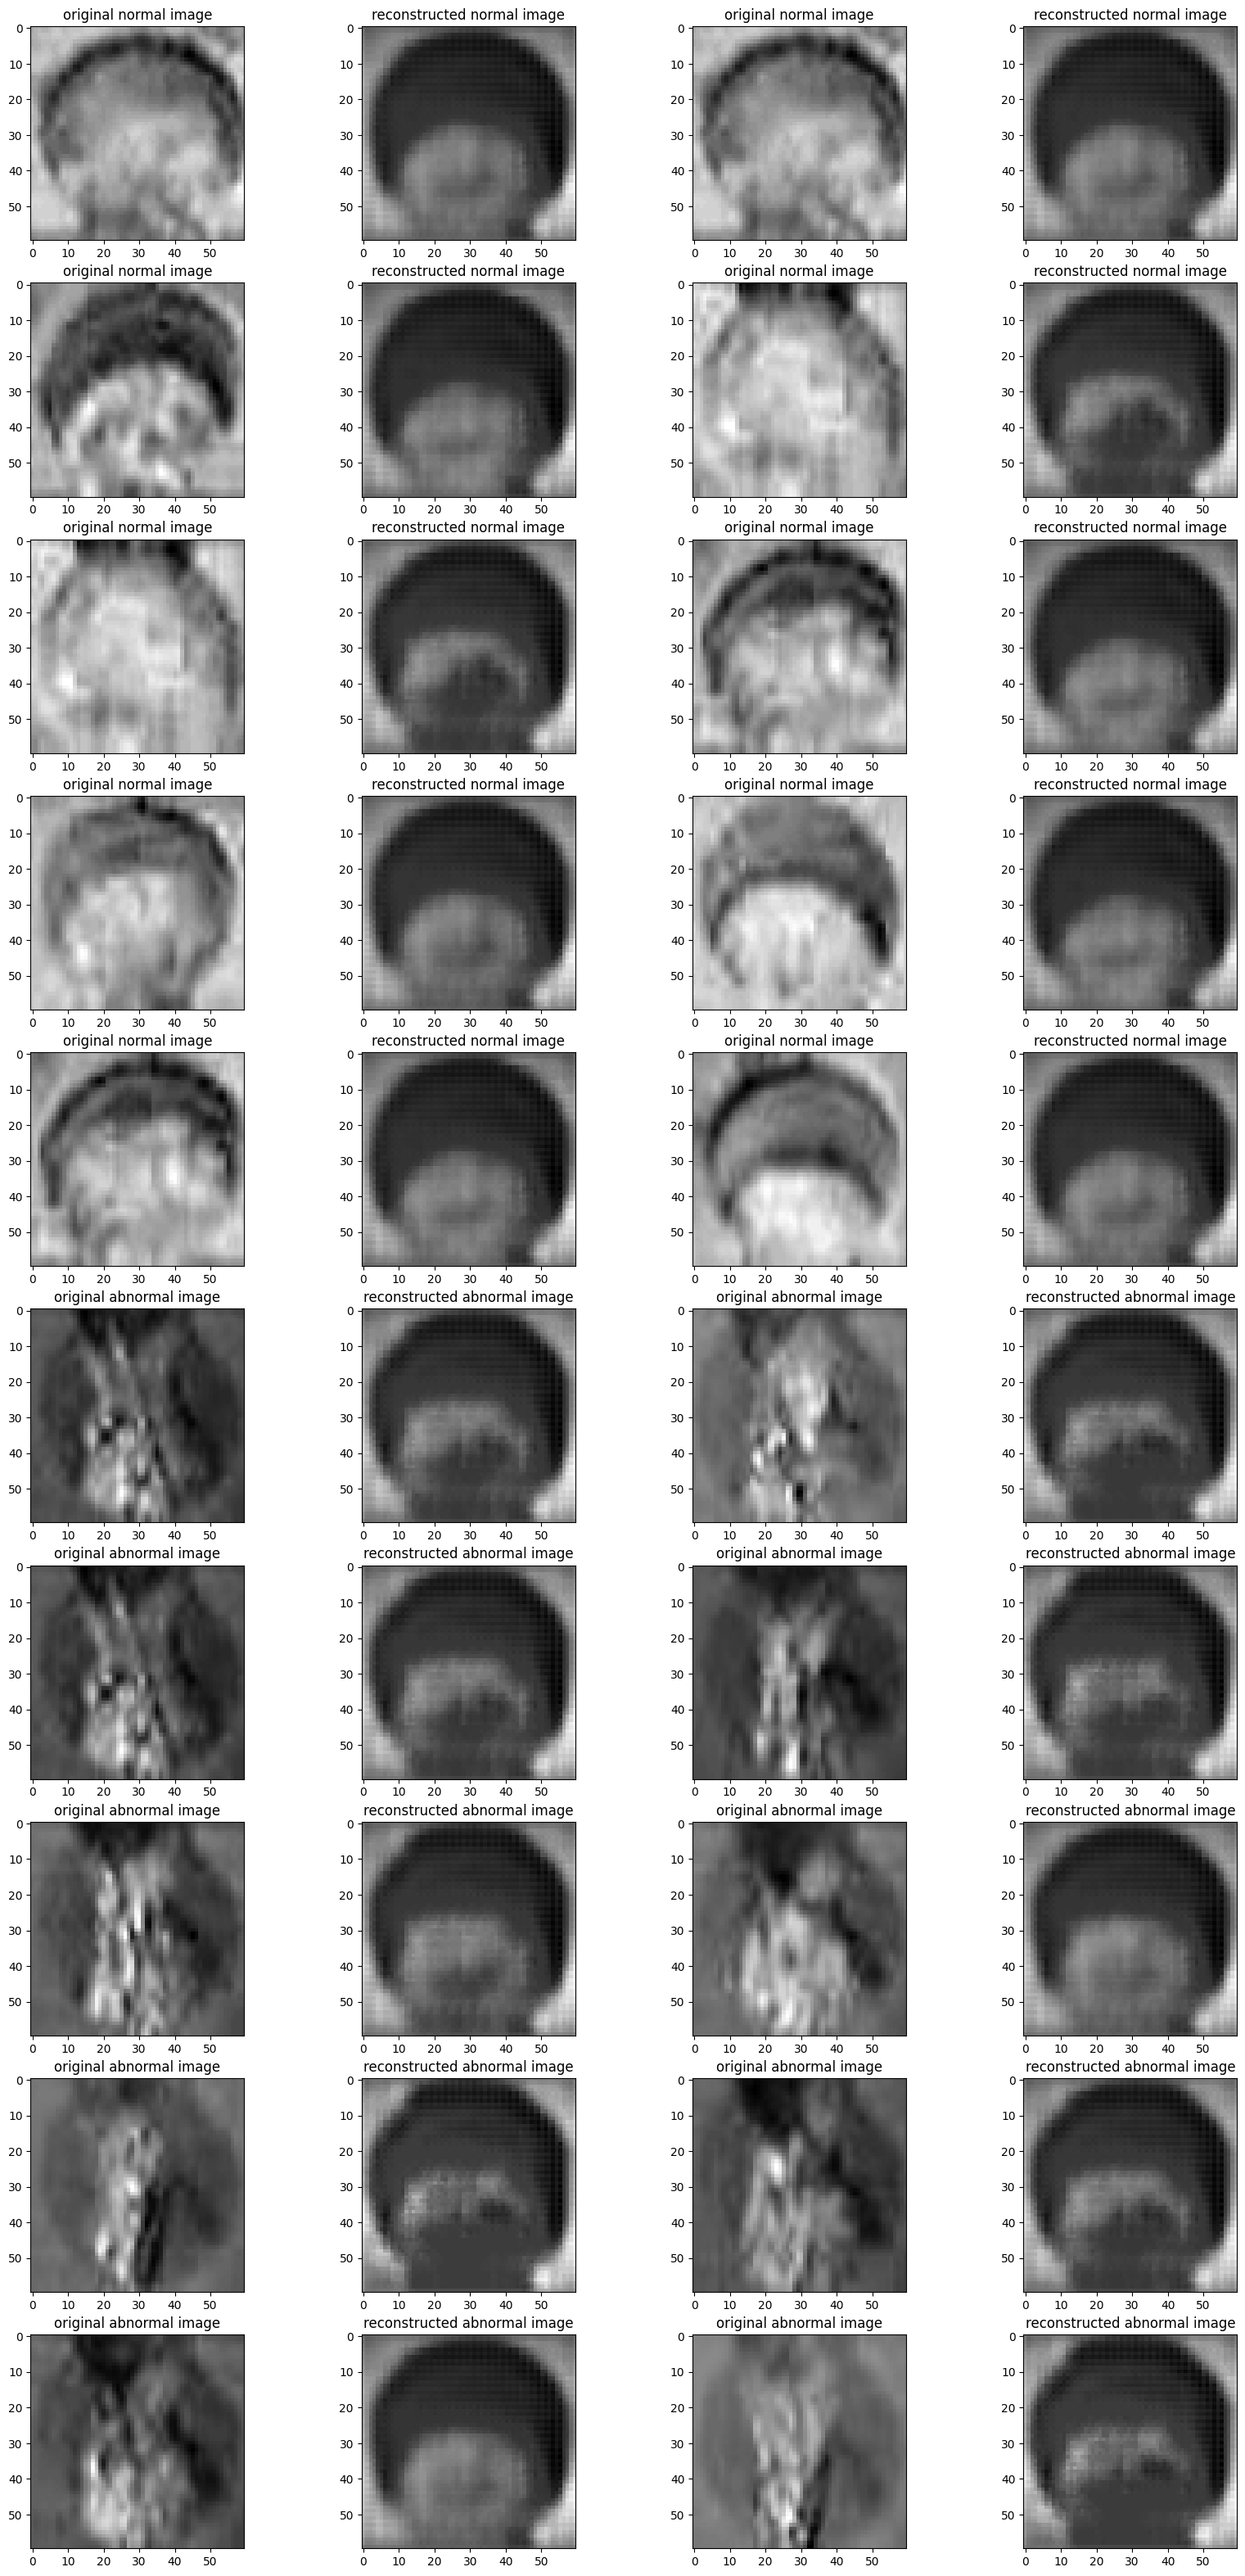

In [381]:
fig, axes = plt.subplots(ncols=4, nrows=10, figsize=(20, 40))

x = next(iter(train_loader))[0]
x_reconstructed = model(x.to('cuda'))

for i in range(5):
    axes[i, 0].imshow(x.detach().cpu().numpy()[i][0], cmap='gray')
    axes[i, 1].imshow(x_reconstructed.detach().cpu().numpy()[i][0], cmap='gray')

    axes[i, 0].set_title('original normal image')
    axes[i, 1].set_title('reconstructed normal image')

    axes[i, 2].imshow(x.detach().cpu().numpy()[i*2][0], cmap='gray')
    axes[i, 3].imshow(x_reconstructed.detach().cpu().numpy()[i*2][0], cmap='gray')

    axes[i, 2].set_title('original normal image')
    axes[i, 3].set_title('reconstructed normal image')

x = next(iter(abnormal_images_loader))[0]
x_reconstructed = model(x.to('cuda'))

for i in range(5, 10):
    axes[i, 0].imshow(x.detach().cpu().numpy()[i][0], cmap='gray')
    axes[i, 1].imshow(x_reconstructed.detach().cpu().numpy()[i][0], cmap='gray')

    axes[i, 0].set_title('original abnormal image')
    axes[i, 1].set_title('reconstructed abnormal image')

    axes[i, 2].imshow(x.detach().cpu().numpy()[i*2][0], cmap='gray')
    axes[i, 3].imshow(x_reconstructed.detach().cpu().numpy()[i*2][0], cmap='gray')

    axes[i, 2].set_title('original abnormal image')
    axes[i, 3].set_title('reconstructed abnormal image')

Внезапно подобное усреднение результатов реконструкции улучшает качество классификации в конце

In [382]:
def calculate_metrics(original_images, reconstructed_images, labels, err_thr):
    reconstruction_errors = criterion_wo_reduction(reconstructed_images, original_images).mean(dim=(1, 2, 3)).numpy()

    predicted_labels = np.zeros((reconstruction_errors.shape[0], ))
    predicted_labels[reconstruction_errors > err_thr] = 1

    TP = ((predicted_labels + labels) == 2).sum()
    TN = ((predicted_labels + labels) == 0).sum()

    TPR = TP / (labels == 1).sum()
    TNR = TN / (labels == 0).sum()

    return TPR, TNR

TPRs = list()
TNRs = list()

original_images = torch.cat([abnormal_original_images, train_original_images])
reconstructed_images = torch.cat([abnormal_reconstructed_images, train_reconstructed_images])

labels = np.array([1]*abnormal_original_images.shape[0] + [0]*train_original_images.shape[0])
train_val_reconstruction_errors = criterion_wo_reduction(reconstructed_images, original_images).mean(dim=(1, 2, 3)).numpy()

linspace_params = (train_val_reconstruction_errors.min(), train_val_reconstruction_errors.max(), 200)

for thr in np.linspace(*linspace_params):
    TPR, TNR = calculate_metrics(original_images, reconstructed_images, labels, thr)

    TPRs.append(TPR)
    TNRs.append(TNR)

best threshold: 0.0022 with TPR=0.961 TNR=0.963


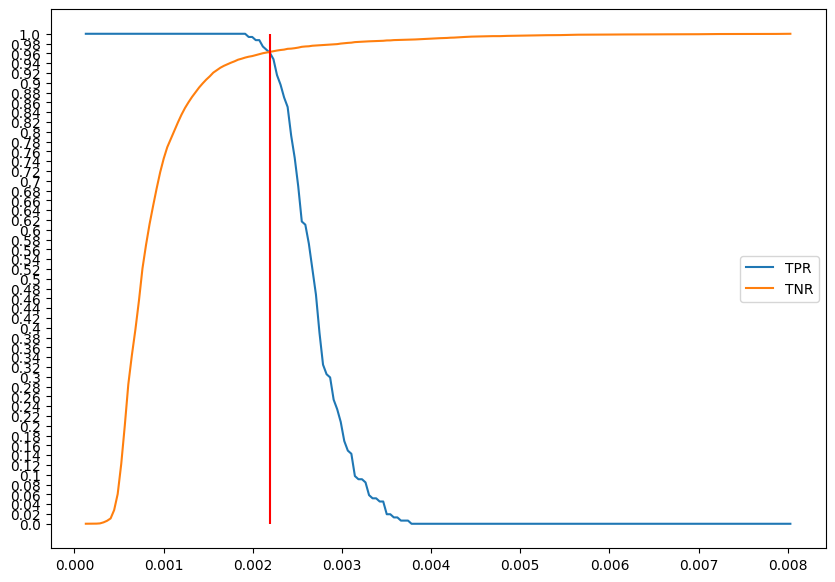

In [383]:
plt.figure(figsize=(10, 7))

plt.plot(np.linspace(*linspace_params), TPRs, label='TPR') 
plt.plot(np.linspace(*linspace_params), TNRs, label='TNR')

best_thr = np.linspace(*linspace_params)[np.argmin(np.abs(np.array(TPRs)-np.array(TNRs)))]
plt.vlines([best_thr], 0, 1, colors=['red'])

plt.yticks(np.round(np.linspace(0, 1, 51), 2), np.round(np.linspace(0, 1, 51), 2))

plt.legend()

TPR, TNR = calculate_metrics(original_images, reconstructed_images, labels, best_thr)
print(f'best threshold: {round(best_thr, 4)} with TPR={round(TPR, 3)} TNR={round(TNR, 3)}')

# Тесты

In [384]:
images_test = {fn: cv2.imread(os.path.join('./dataset/test/imgs', fn)) for fn in tqdm(os.listdir('./dataset/test/imgs'))}
with open('./dataset/test/test_annotation.txt') as f:
    lines = f.readlines()
    lines = [x.strip().split() for x in lines]

    markup = {x[0]: int(x[1]) for x in lines}

images_test = list(dict(sorted(images_test.items(), key=lambda x: x[0])).values())
images_test = torch.stack(list(map(initial_transforms, images_test)))
images_test = T.Normalize(mean=0, std=1)(images_test)

markup = list(dict(sorted(markup.items(), key=lambda x: x[0])).values())

images_test.shape

  0%|          | 0/3794 [00:00<?, ?it/s]

torch.Size([3794, 1, 60, 60])

In [385]:
reconstructed_images = list()

for i in range(images_test.shape[0] // batch_size + (images_test.shape[0] % batch_size != 0)):
    with torch.no_grad():
        reconstructed_images.append(model(images_test[i*batch_size: (i+1)*batch_size].to('cuda')).cpu())

reconstructed_images = torch.cat(reconstructed_images, dim=0)
reconstructed_images.shape

torch.Size([3794, 1, 60, 60])

torch.Size([3794])


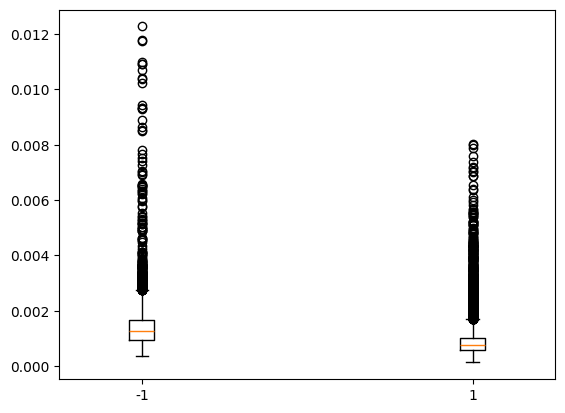

In [386]:
reconstruction_errors = criterion_wo_reduction(reconstructed_images, images_test).mean(dim=(1, 2, 3))
print(reconstruction_errors.shape)

plt.boxplot(reconstruction_errors, positions=[-1])
plt.boxplot(train_val_reconstruction_errors, positions=[1]);

In [387]:
def calculate_metrics(original_images, reconstructed_images, labels, err_thr):
    reconstruction_errors = criterion_wo_reduction(reconstructed_images, original_images).mean(dim=(1, 2, 3)).numpy()

    predicted_labels = np.zeros((reconstruction_errors.shape[0], ))
    predicted_labels[reconstruction_errors > err_thr] = 1

    TP = ((predicted_labels + labels) == 2).sum()
    TN = ((predicted_labels + labels) == 0).sum()

    TPR = TP / (labels == 1).sum()
    TNR = TN / (labels == 0).sum()

    return TPR, TNR

TPRs = list()
TNRs = list()

reconstruction_errors = criterion_wo_reduction(reconstructed_images, images_test).mean(dim=(1, 2, 3)).numpy()
linspace_params = (reconstruction_errors.min(), reconstruction_errors.max(), 200)

for thr in np.linspace(*linspace_params):
    TPR, TNR = calculate_metrics(images_test, reconstructed_images, np.array(markup), thr)

    TPRs.append(TPR)
    TNRs.append(TNR)

train data estimated threshold: 0.002192 with TPR=0.915 TNR=0.918
best threshold: 0.002207 with TPR=0.915 TNR=0.92


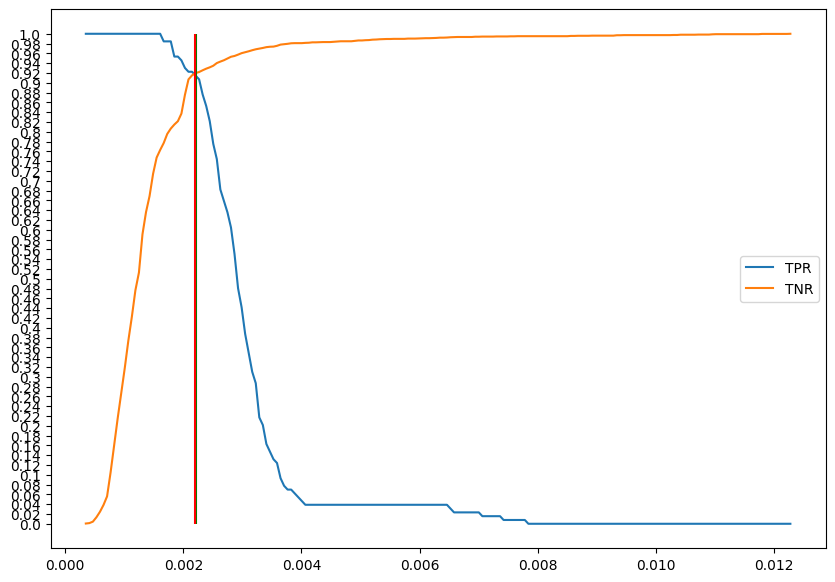

In [388]:
plt.figure(figsize=(10, 7))

plt.plot(np.linspace(*linspace_params), TPRs, label='TPR') 
plt.plot(np.linspace(*linspace_params), TNRs, label='TNR')

best_thr_test = np.linspace(*linspace_params)[np.argmin(np.abs(np.array(TPRs)-np.array(TNRs)))]
plt.vlines([best_thr_test, best_thr], 0, 1, colors=['green', 'red'])

plt.yticks(np.round(np.linspace(0, 1, 51), 2), np.round(np.linspace(0, 1, 51), 2))

plt.legend()

TPR, TNR = calculate_metrics(images_test, reconstructed_images, np.array(markup), best_thr)
print(f'train data estimated threshold: {round(best_thr, 6)} with TPR={round(TPR, 3)} TNR={round(TNR, 3)}')
TPR, TNR = calculate_metrics(images_test, reconstructed_images, np.array(markup), best_thr_test)
print(f'best threshold: {round(best_thr_test, 6)} with TPR={round(TPR, 3)} TNR={round(TNR, 3)}')

Для тестовых данный трешхолд подобрался немного иной, но и подобранный на трейне показывает хорошо